# Zero-dimensional model of sediment accumulation on Polder 32 in Southwest Bangladesh

Import packages

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import subprocess
import feather
from tqdm.notebook import tqdm
import multiprocessing as mp
import itertools
import inspect
import shutil

Set project directory

In [2]:
if sys.platform == 'linux':
    os.chdir('/home/chris/projects/tidal_flat_0d/')
elif sys.platform == 'win32':
    os.chdir('..')

Create subfunctions

In [3]:
# Call Rscript and use OCE package to create idealized tide form to be used in model
def make_tides(slr):
    global run_length, dt

    if sys.platform == 'win32':
        Rscript = "C:\\Program Files\\R\\R-3.6.3\\bin\\Rscript.exe"
    else:
        Rscript = "Rscript"
        
    wdir = os.getcwd()
    path = os.path.join(wdir,'scripts/make_tides.R')
    subprocess.run([Rscript, path, str(run_length), str(dt), '%.4f' % slr, wdir])
    
    tides = feather.read_dataframe('./data/interim/tides/tides-yr_{0}-dt_{1}-slr_{2}.feather'.format(run_length, int(pd.to_timedelta(dt).total_seconds()/60/60), '%.4f' % slr))
    tides = tides.set_index('Datetime')
    
    return tides

# Return suspended sediment values from a csv of average weekly suspended sediment for P32. When tide is below the
# the platform (no sedimentation) or the tide is falling (net export), "0" is returned.
def calc_c0(h, dh, z, A, timestamp):
    global ssc_by_week

    if (h > z and dh > 0):
        week = timestamp.week
        ssc = ssc_by_week.loc[week].values[0]
        return A * ssc
    else:
        return 0

# Calculate the concentration within the water column for a given timestep
def calc_c(c0, h, h_min_1, dh, c_min_1, z, ws, dt):
    if (h > z and dh > 0):
        return (c0 * (h-h_min_1) + c_min_1 * (h - z)) / (2 * h - h_min_1 - z + ws * dt)
    elif (h > z and dh < 0):
        return (c_min_1 * (h - z)) / (h - z + ws * dt)
    else:
        return 0

# Calculate the change in elevation for a given timestep    
def calc_dz(c, ws, rho, dt):
    return (ws * c / rho) * dt

# Add the change of elevation back to the original elevation
def calc_z(z_min_1, dz_min_1, dO, dP):
    return z_min_1 + dz_min_1 + dO - dP

Create main functions

In [24]:
# Creates a list of tides to be created. Useful when parallelizing and need to create tides in advance.
def make_tide_list(slr_list):
    
    if isinstance(slr_list, list):
        pass
    elif isinstance(slr_list, float):
        slr_list = [slr_list]
        
    tides_to_make = []
    for rate in slr_list:
        file = './data/interim/tides/tides-yr_{0}-dt_{1}-slr_{2}.feather'.format(run_length, int(pd.to_timedelta(dt).total_seconds()/60/60), '%.4f' % rate)
        if not os.path.isfile(file):
            tides_to_make.append(rate)
            
    return tides_to_make

# Main function for running the model.
def run_model(tides, grain_dia, grain_rho, bulk_rho, dP, dO, dM, A, z0, n=None):
    global ssc_by_week, num_runs
    
    # Set Datetime as the index. Feather does not export non-integer indices.
    tides = tides.set_index('Datetime')
    index = tides.index
    dt = index[1] - index[0]
    dt_sec = dt.total_seconds()
    
    # Assume density and viscosity of water
    fluid_rho = 1000
    fluid_visc = 0.001
    g = 9.8
    
    # Calculate settling velocity using Stokes settling. Considered an upper bound for possible settling velocity.
    ws = (2/9 * (grain_rho - fluid_rho) / fluid_visc) * g * (grain_dia / 2) ** 2
    
    # Initialize numpy arrays for efficiency
    z = np.zeros(len(tides.index))
    h = tides.pressure.values
    dh = np.insert(np.diff(h) / dt_sec,0,np.nan)
    inundated = np.zeros(len(tides.index))
    inundation_depth = np.zeros(len(tides.index))
    C0 = np.zeros(len(tides.index))
    C = np.zeros(len(tides.index))
    dz = np.zeros(len(tides.index))
    
    # For loop to calculate backwards difference approximation.
    # TQDM is a wrapper that shows a status bar while calculating.
    counter = np.arange(1,len(index))
    for t in tqdm(counter, 
                  desc='Run {0} of {1} [PID: {2}]'.format(n, num_runs, os.getpid()), 
                  total=len(index[1:]), 
                  unit='steps'):
        z[t] = calc_z(z[t-1], dz[t-1], 0, 0)
        C0[t] = calc_c0(h[t], dh[t], z[t], A, index[t])
        C[t] = calc_c(C0[t], h[t], h[t-1], dh[t], C[t-1], z[t], ws, dt_sec)
        dz[t] = calc_dz(C[t], ws, bulk_rho, dt_sec)
        
        # Flag if inundated and by how much
        if h[t] - z[t] >= 0:
            inundated[t] = 1
            inundation_depth[t] = h[t] - z[t]
    
    # Calculate cumulative inundation time
    hours_inundated = int(np.sum(inundated) * dt_sec / 60)

    # Return final elevation
    final_elevation = z[-1]
    
    # Create pandas dataframe from numpy arrays of finite difference results
    d = {'h' : h, 'dh' : dh, 'C0' : C0, 'C' : C, 'dz' : dz, 'z' : z, 
         'inundated' : inundated, 'inundation_depth' : inundation_depth}
    df = pd.DataFrame(data=d, index = tides.index)
    
        
    return df, hours_inundated, final_elevation

Create helper functions for parallel processing

In [25]:
# Creates combination of parameter values for different scenarios
def make_combos(run_length, dt, slr, ssc_factor, grain_diameter, grain_rho, bulk_rho, dP, dO, dM, A, z0):
    
    # Use inspect function to get all of the input arguments
    args = inspect.getfullargspec(make_combos).args
    
    # Initialize arguments list and counter
    multi_args = []
    n = 0
    
    # Loop through all arguments and extract arguments with multiple values (i.e. arguments that will be varied)
    for arg in args:
        if isinstance(eval(arg), (list, tuple, np.ndarray)):
            multi_args.append(arg)
            
    # Extract the arguments with one value (i.e. arguments that will remain constant)
    single_args = list(set(args) - set(multi_args))
    
    # Create a dictionary of single value arguments
    single_dict = [{'{0}'.format(j) : eval(j)} for j in single_args]
    
    # Initialize output with combination of all multi value arguments
    combos = [dict(zip(multi_args, i)) for i in itertools.product(*[eval(x) for x in multi_args])]
    
    # Iterate through all combinations of dictionary key:value pairs and add single value arguments
    for combo in combos:
        for item in single_dict:
            combo.update(item)
        combo.update({'n' : n}) # combination number for tracking in TQDM
        n = n + 1

    return combos

# Function to be called by parallel function (e.g. imap_unordered). This is necessary because imap only accepts
# one function and one iterable. Using this parser allows the model to be run with multiple iterables package as 
# one tuple
def parallel_parser(in_data):
    global ssc_by_week

    n = in_data['n'] # number to explicitly set print line for TQDM. Not working.
    
    # Load tides for a given run_length, dt, and slr from the tide library.
    run_length = in_data['run_length']
    dt = in_data['dt']
    slr = in_data['slr']
    tides = feather.read_dataframe(
        './data/interim/tides/tides-yr_{0}-dt_{1}-slr_{2}.feather'.format(run_length, 
                                                                          int(pd.to_timedelta(dt).total_seconds()/60/60), 
                                                                          '%.4f' % slr))
    # Set Datetime as the index. Feather does not export non-integer indices.
    tides = tides.set_index('Datetime')
    
    # Load weekly ssc data. Original data from OBS sensor deployed at Sutarkhali. Data is in 1-min increments. Developed
    # a model to predict SSC by week of the year (incoming_ssc.R). Output of this script is the weekly SSC loaded here.
    ssc_factor = in_data['ssc_factor'] # scaling factor used to adjust SSC
    ssc_file = './data/processed/ssc_by_week.csv'
    ssc_by_week = pd.read_csv(ssc_file, index_col=0) * ssc_factor
    
    # set parameters for model run
    grain_dia = in_data['grain_dia']
    grain_rho = in_data['grain_rho']
    bulk_rho = in_data['bulk_rho']
    dP = in_data['dP']
    dO = in_data['dO']
    dM = in_data['dM']
    A = in_data['A']
    z0 = in_data['z0']
    
    # run model
    run_model(tides, grain_dia, grain_rho, bulk_rho, dP, dO, dM, A, z0, n=n)
    
    # Write results to a feather file
    out_name = 'yr_{0}-slr_{1}-grain_dia_{2}-grain_rho_{3}-bulk_rho_{4}-sscfactor_{5}-dP_{6}-dM_{7}-A_{8}-z0_{9}.feather'.format(run_length, slr, grain_dia, grain_rho, bulk_rho, ssc_factor, dP, dM, A, z0)
    feather.write_dataframe(df.reset_index(), './data/interim/results/{0}'.format(out_name))

    return

Set parameters for the model run. Parameters must be single values (single core) or a list of values (parallel processing). If parallel flag is set to "True", the parallel method will be used.

In [26]:
parallel = False

# Additional parameters needed for parallelization
if parallel == True:
    poolsize = 30
    chunksize = 1
    
    # Quickly define regular interval for varying parameters. Can also be explicitly set.
    slr = np.round(np.arange(0, 0.0325, 0.0025), 4)
    ssc_factor = np.round(np.arange(0.25, 3.25, 0.25), 2)

# Set model parameters
run_length = 50
dt = '1 hour' # timestep must be given as a timedelta string
slr = 0.002
ssc_factor = 1
grain_dia = 0.035
grain_rho = 2650 # density of quartz
bulk_rho = 1300
dP = 0
dO = 0
dM = 0.003
A = 0.75
z0 = 0

Make all tides before running the model.

In [27]:
tides_to_make = make_tide_list(slr)

if len(tides_to_make) == 0:
    print('All tidal curves already constructed!')
elif len(tides_to_make) == 1:
    make_tides(slr)
elif len(tides_to_make) >=2:
    print('Making {0} tidal curves.'.format(len(tides_to_make)))
    with mp.Pool(poolsize) as pool:
        for new_tide in tqdm(pool.imap_unordered(make_tides, tides_to_make),
                  total=len(tides_to_make),
                  unit='tidal curves'):
            pass

All tidal curves already constructed!


In [28]:
# Parallel method
if parallel == True:
    
    # Make combos of parameters
    model_runs = make_combos(run_length, dt, slr, ssc_factor, grain_dia, grain_rho, bulk_rho, dP, dO, dM, A, z0)
    
    # Count number of models to be run
    num_runs = len(model_runs)

    # Initialize pool and run models
    with mp.Pool(poolsize) as pool:
        for result in pool.imap_unordered(parallel_parser, model_runs, chunksize=chunksize):
            pass

# Single core method
elif parallel == False:
    
    # Load tides from tide library
    tides = feather.read_dataframe('./data/interim/tides/tides-yr_{0}-dt_{1}-slr_{2}.feather'.format(
        run_length, int(pd.to_timedelta(dt).total_seconds()/60/60), '%.4f' % slr))

    # Load weekly ssc data. Original data from OBS sensor deployed at Sutarkhali. Data is in 1-min increments. Developed
    # a model to predict SSC by week of the year (incoming_ssc.R). Output of this script is the weekly SSC loaded here.
    ssc_file = './data/processed/ssc_by_week.csv'
    ssc_by_week = pd.read_csv(ssc_file, index_col=0) * ssc_factor
    
    # Set number of models to be run
    num_runs = 1

    # run model
    df, hours_inundated, final_elevation = run_model(tides, grain_dia, grain_rho, bulk_rho, dP, dO, dM, A, z0, n=1)
    
    # write results to feather file
    out_name = 'yr_{0}-slr_{1}-grain_dia_{2}-grain_rho_{3}-bulk_rho_{4}-sscfactor_{5}-dP_{6}-dM_{7}-A_{8}-z0_{9}.feather'.format(run_length, slr, grain_dia, grain_rho, bulk_rho, ssc_factor, dP, dM, A, z0)
    feather.write_dataframe(df.reset_index(), './data/interim/results/{0}'.format(out_name))

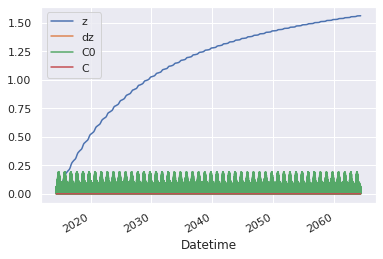

In [30]:
df.plot(y = ['z', 'dz', 'C0', 'C'])